## Taking a Snapshot of the 2D Central Axial Slice with and without segmentation mask 

In [9]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os

In [10]:
def get_center_slice(img):
    #img is a Nifti1Image object
    data = img.get_fdata()
    center = data.shape[2] // 2     #Assuming the third dimension is the axial dimension
    return data[:, :, center]

In [16]:
def plot_slices(mri_slice, seg_slice, omit_background=True, show=True, save_path=None):
    # Create a masked array where only values 1, 2, and 3 are included
    # and other values are set to be transparent
    mask = np.isin(seg_slice, [1, 2, 3])
    masked_seg_slice = np.where(mask, seg_slice, np.nan)  # Replace 0s with NaN for transparency

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(mri_slice.T, cmap='gray', origin='lower')
    ax[1].imshow(mri_slice.T, cmap='gray', origin='lower')

    if omit_background==True:
        # Only overlay areas where mask is True, with the segmentation mask using a colormap
        ax[1].imshow(masked_seg_slice.T, cmap='jet', alpha=0.5, origin='lower')
        
    else:
        ax[1].imshow(seg_slice.T, cmap='jet', alpha = 0.5, origin='lower')      #Overlay with transparency

    if save_path:
        plt.savefig(save_path)  # Save the figure to the specified path

    if show:
        plt.show()      # Show the plot if requested
    else:
        plt.close(fig)  # Only close the figure if not showing it

In [ ]:
def plot_slices(mri_slice, seg_slice, omit_background=True, show=True, save_path=None):
    # Create a masked array where only values 1, 2, and 3 are included
    # and other values are set to be transparent
    mask = np.isin(seg_slice, [1, 2, 3])
    masked_seg_slice = np.where(mask, seg_slice, np.nan)  # Replace 0s with NaN for transparency

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(mri_slice.T, cmap='gray', origin='lower')
    ax[1].imshow(mri_slice.T, cmap='gray', origin='lower')

    if omit_background==True:
        # Only overlay areas where mask is True, with the segmentation mask using a colormap
        ax[1].imshow(masked_seg_slice.T, cmap='jet', alpha=0.5, origin='lower')
        
    else:
        ax[1].imshow(seg_slice.T, cmap='jet', alpha = 0.5, origin='lower')      #Overlay with transparency

    if save_path:
        plt.savefig(save_path)  # Save the figure to the specified path

    if show:
        plt.show()      # Show the plot if requested
    else:
        plt.close(fig)  # Only close the figure if not showing it

In [12]:
def process_mri_and_segmentation(mri_path, seg_path, export_dir=None):
    mri_img = nib.load(mri_path)
    seg_img = nib.load(seg_path)

    mri_slice = get_center_slice(mri_img)
    seg_slice = get_center_slice(seg_img)

     # If export directory is specified, save the images
    if export_dir:
        if not os.path.exists(export_dir):
            os.makedirs(export_dir)
         # Extract the base name of the MRI file without the file extension
        base_name = os.path.splitext(os.path.basename(mri_path))[0]
        save_path = os.path.join(export_dir, f'{base_name}_center_slice.png')
        plot_slices(mri_slice, seg_slice, show=True, save_path=save_path)
    else:    
        plot_slices(mri_slice, seg_slice)

    return{
        "mri_slice":mri_slice,
        "segmentation_slice":seg_slice

    }

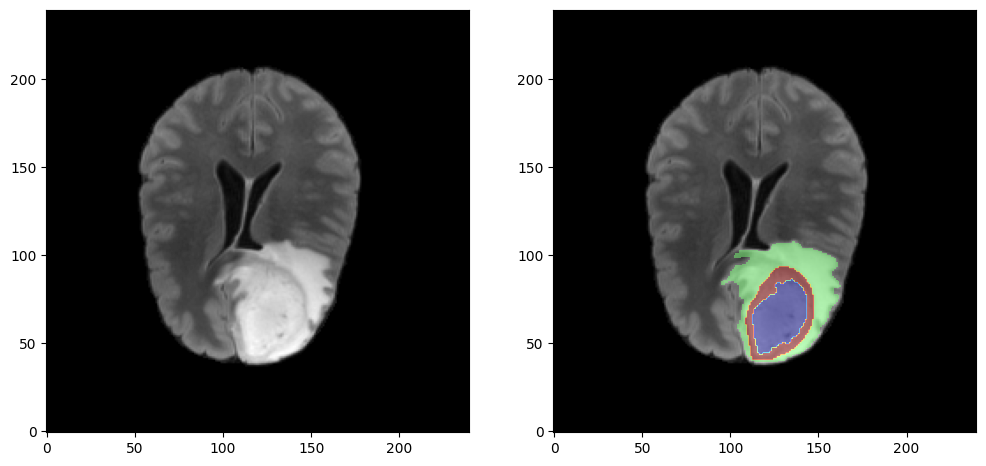

In [17]:
#Example usage
base_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00006-000/BraTS-GLI-00006-000'
mri_path =  base_path + '-t2f.nii.gz'
seg_path = base_path + '-seg.nii.gz'
export_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00003-000/'
result = process_mri_and_segmentation(mri_path, seg_path, None)

### TPTBox Functionalities

In [9]:
import TPTBox
from TPTBox import *

In [10]:
bids_nii = NII(nib.load(mri_path))
print("shape", bids_nii.shape)

shape (240, 240, 155)


In [13]:
bids_nii = NII.load(mri_path, False)

## Converting the Nifti files into numpy arrays for training a model

### 1. Loading NIfTI Data as NumPy Arrays

In [8]:
import nibabel as nib
import numpy as np

def load_nifti_as_array(file_path):
    # Load the file, and convert to a numpy array
    nifti_image = nib.load(file_path)
    return np.array(nifti_image.get_fdata(), dtype=np.float32)

### 2. Extracting the Central Axial Slice

In [9]:
def get_central_axial_slice(np_array):
    center_index = np_array.shape[2] // 2
    return np_array[:, :, center_index]


### 3. Normalization

In [10]:
def normalize(slice_array):
    mean = np.mean(slice_array)
    std = np.std(slice_array)
    normalized_slice = (slice_array - mean) / std if std > 0 else slice_array
    return normalized_slice

### 4. Create a PyTorch Dataset

In [11]:
import torch
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = load_nifti_as_array(self.image_files[idx])
        mask = load_nifti_as_array(self.mask_files[idx])

        image_slice = get_central_axial_slice(image)
        mask_slice = get_central_axial_slice(mask)

        image_slice = normalize(image_slice)
        mask_slice = np.array(mask_slice, dtype=np.int64)  # Ensure mask is integer type

        if self.transform:
            image_slice = self.transform(image_slice)
            mask_slice = self.transform(mask_slice)

        # Add a channel dimension and convert to tensors
        image_slice = torch.from_numpy(image_slice).unsqueeze(0).float()
        mask_slice = torch.from_numpy(mask_slice).unsqueeze(0).long()

        return image_slice, mask_slice


### Test the BraTSDataset Class

In [12]:
dataset = BraTSDataset(mri_path, seg_path)

In [21]:
mri_nparray = load_nifti_as_array(mri_path)
print("numpy array", mri_nparray)

numpy array [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

In [22]:
print("non-zero:", np.nonzero(mri_nparray))

non-zero: (array([ 54,  54,  54, ..., 186, 186, 186]), array([121, 121, 121, ..., 139, 142, 143]), array([61, 62, 63, ..., 68, 68, 68]))


In [24]:
mri_centralslice = get_central_axial_slice(mri_nparray)
print(mri_centralslice)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


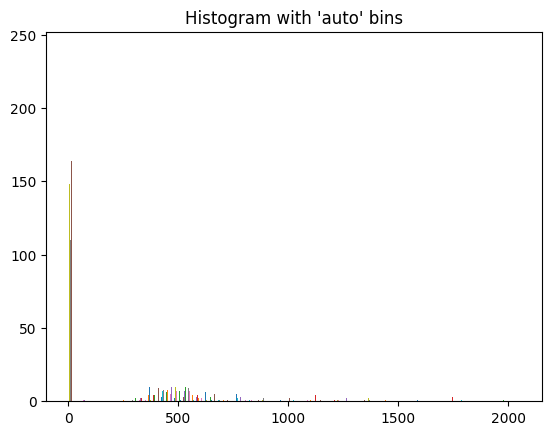

In [25]:
_ = plt.hist(mri_centralslice, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

# Checking Voxel value range for sample Niftis

### Single Folder

In [30]:
import nibabel as nib
import numpy as np
import os

directory_path = '/media/DATA/farid_ma/dev/datasets/ASNR-MICCAI-BraTS2023-GLI-Challenge/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00002-000'

# Iterate over each file in the directory
for file_name in os.listdir(directory_path):
    if file_name.endswith('.nii.gz'):
        file_path = os.path.join(directory_path, file_name)
        img = nib.load(file_path)
        data = img.get_fdata()
        min_value = np.min(data)
        max_value = np.max(data)
        print(f"{file_name}: Min={min_value}, Max={max_value}")

BraTS-GLI-00002-000-t1n.nii.gz: Min=0.0, Max=2300.0
BraTS-GLI-00002-000-seg.nii.gz: Min=0.0, Max=3.0
BraTS-GLI-00002-000-t1c.nii.gz: Min=0.0, Max=12137.0
BraTS-GLI-00002-000-t2w.nii.gz: Min=0.0, Max=2217.0
BraTS-GLI-00002-000-t2f.nii.gz: Min=0.0, Max=2563.0


### Whole Directory

In [39]:
import os
import nibabel as nib
import numpy as np

def process_nifti_files(directory_path):
    last_subject = None

    # Walk through all directories and files in the path
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                # Extract subject identifier from the filename
                subject_id = file.split('-')[2]  # Adjust this index depending on the exact format

                if subject_id != last_subject:
                    if last_subject is not None:
                        print('-' * 40)  # Print separation line when a new subject begins
                    last_subject = subject_id

                file_path = os.path.join(root, file)
                try:
                    # Load the NIfTI file
                    img = nib.load(file_path)
                    data = img.get_fdata()

                    # Calculate the minimum and maximum voxel values
                    min_value = np.min(data)
                    max_value = np.max(data)

                    print(f"File: {file} - Min: {min_value}, Max: {max_value}")
                except Exception as e:
                    print(f"Failed to process {file}: {e}")

    if last_subject is not None:
        print('-' * 40)  # Print final separation line at the end of processing

# Set the top level of your BIDS directory
bids_directory_path = '/media/DATA/farid_ma/dev/datasets/ASNR-MICCAI-BraTS2023-GLI-Challenge/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'
process_nifti_files(bids_directory_path)


File: BraTS-GLI-00026-000-t2f.nii.gz - Min: 0.0, Max: 3531.0
File: BraTS-GLI-00026-000-t1c.nii.gz - Min: 0.0, Max: 14480.0
File: BraTS-GLI-00026-000-t1n.nii.gz - Min: 0.0, Max: 2304.0
File: BraTS-GLI-00026-000-t2w.nii.gz - Min: 0.0, Max: 3398.0
File: BraTS-GLI-00026-000-seg.nii.gz - Min: 0.0, Max: 3.0
----------------------------------------
File: BraTS-GLI-00002-000-t1n.nii.gz - Min: 0.0, Max: 2300.0
File: BraTS-GLI-00002-000-seg.nii.gz - Min: 0.0, Max: 3.0
File: BraTS-GLI-00002-000-t1c.nii.gz - Min: 0.0, Max: 12137.0
File: BraTS-GLI-00002-000-t2w.nii.gz - Min: 0.0, Max: 2217.0
File: BraTS-GLI-00002-000-t2f.nii.gz - Min: 0.0, Max: 2563.0
----------------------------------------
File: BraTS-GLI-00799-000-t1n.nii.gz - Min: 0.0, Max: 944.82470703125
File: BraTS-GLI-00799-000-t1c.nii.gz - Min: 0.0, Max: 1627.9290771484375
File: BraTS-GLI-00799-000-seg.nii.gz - Min: 0.0, Max: 3.0
File: BraTS-GLI-00799-000-t2f.nii.gz - Min: 0.0, Max: 1323.3531494140625
File: BraTS-GLI-00799-000-t2w.nii.gz -

### Visualization of Max Values for whole folder

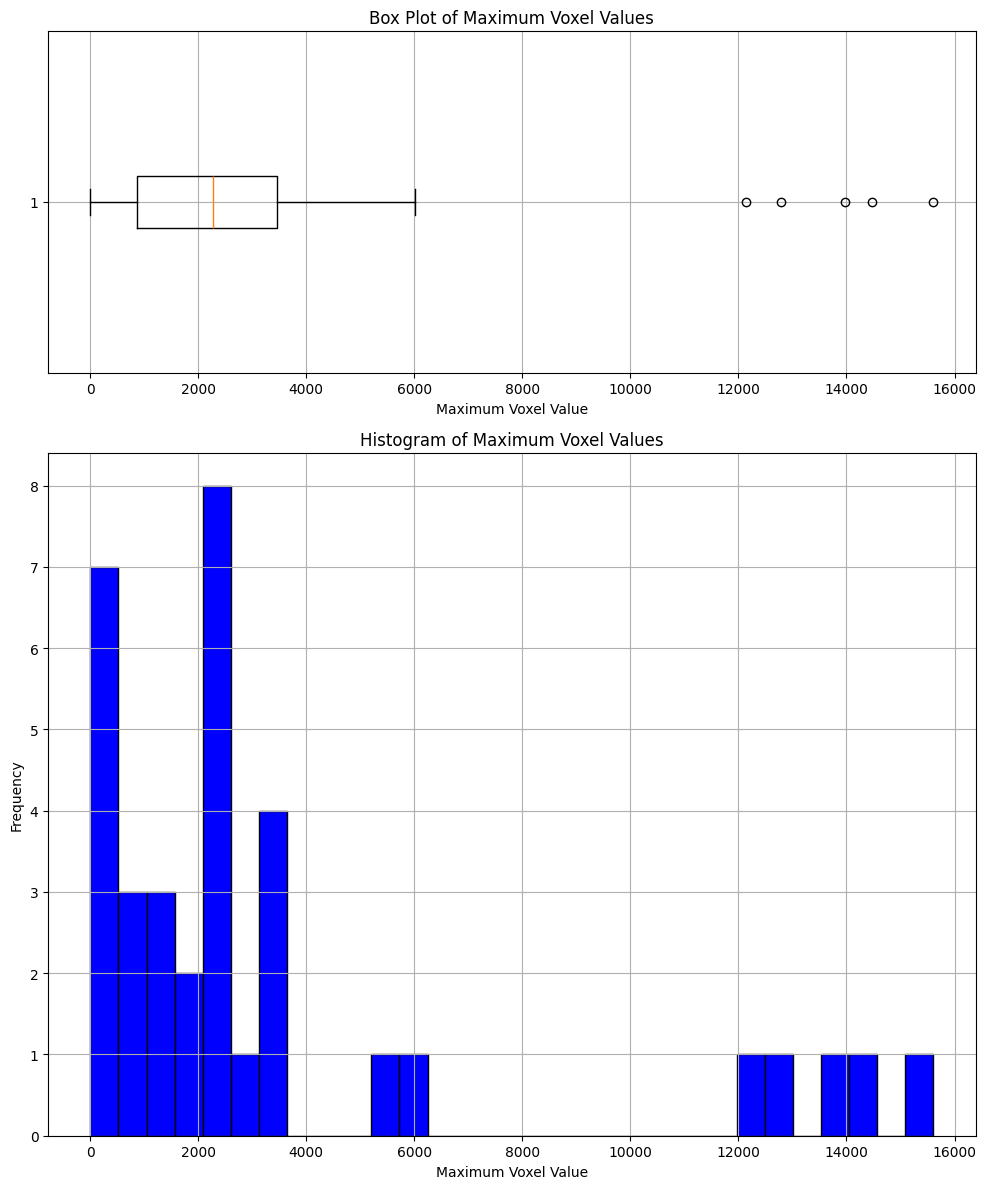

In [3]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def collect_max_values(directory_path):
    max_values = []
    file_names = []  # Optional: Collect file names if you want to reference specific files

    # Walk through all directories and files in the path
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                file_path = os.path.join(root, file)
                try:
                    # Load the NIfTI file
                    img = nib.load(file_path)
                    data = img.get_fdata()

                    # Collect the maximum voxel value
                    max_values.append(np.max(data))
                    file_names.append(file)  # Optionally collect file names

                except Exception as e:
                    print(f"Failed to process {file}: {e}")

    return max_values, file_names

def plot_max_values(max_values):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1, 2]})

    # Box plot
    axs[0].boxplot(max_values, vert=False)
    axs[0].set_title('Box Plot of Maximum Voxel Values')
    axs[0].set_xlabel('Maximum Voxel Value')
    axs[0].grid(True)

    # Histogram
    axs[1].hist(max_values, bins=30, color='blue', edgecolor='black')
    axs[1].set_title('Histogram of Maximum Voxel Values')
    axs[1].set_xlabel('Maximum Voxel Value')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Set the top level of your BIDS directory
bids_directory_path = '/media/DATA/farid_ma/dev/datasets/ASNR-MICCAI-BraTS2023-GLI-Challenge/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'
max_values, file_names = collect_max_values(bids_directory_path)
plot_max_values(max_values)


# Test with SimpleITK

### Whole Folder

In [2]:
import os
import SimpleITK as sitk
import numpy as np

def process_nifti_files(directory_path):
    last_subject = None

    # Walk through all directories and files in the path
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                # Extract subject identifier from the filename
                subject_id = file.split('-')[2]  # Adjust this index depending on the exact format

                if subject_id != last_subject:
                    if last_subject is not None:
                        print('-' * 40)  # Print separation line when a new subject begins
                    last_subject = subject_id

                file_path = os.path.join(root, file)
                try:
                    # Load the NIfTI file
                    img = sitk.ReadImage(file_path)
                    data = sitk.GetArrayFromImage(img)
                    #img = nib.load(file_path)
                    #data = img.get_fdata()

                    # Calculate the minimum and maximum voxel values
                    min_value = np.min(data)
                    max_value = np.max(data)

                    print(f"File: {file} - Min: {min_value}, Max: {max_value}")
                except Exception as e:
                    print(f"Failed to process {file}: {e}")

    if last_subject is not None:
        print('-' * 40)  # Print final separation line at the end of processing

# Set the top level of your BIDS directory
bids_directory_path = '/media/DATA/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'
process_nifti_files(bids_directory_path)


File: BraTS-GLI-00026-000-t2f.nii.gz - Min: 0, Max: 3531
File: BraTS-GLI-00026-000-t1c.nii.gz - Min: 0, Max: 14480
File: BraTS-GLI-00026-000-t1n.nii.gz - Min: 0, Max: 2304
File: BraTS-GLI-00026-000-t2w.nii.gz - Min: 0, Max: 3398
File: BraTS-GLI-00026-000-seg.nii.gz - Min: 0.0, Max: 3.0
----------------------------------------
File: BraTS-GLI-00002-000-t1n.nii.gz - Min: 0, Max: 2300
File: BraTS-GLI-00002-000-seg.nii.gz - Min: 0.0, Max: 3.0
File: BraTS-GLI-00002-000-t1c.nii.gz - Min: 0, Max: 12137
File: BraTS-GLI-00002-000-t2w.nii.gz - Min: 0, Max: 2217
File: BraTS-GLI-00002-000-t2f.nii.gz - Min: 0, Max: 2563
----------------------------------------
File: BraTS-GLI-00799-000-t1n.nii.gz - Min: 0.0, Max: 944.82470703125
File: BraTS-GLI-00799-000-t1c.nii.gz - Min: 0.0, Max: 1627.9290771484375
File: BraTS-GLI-00799-000-seg.nii.gz - Min: 0.0, Max: 3.0
File: BraTS-GLI-00799-000-t2f.nii.gz - Min: 0.0, Max: 1323.3531494140625
File: BraTS-GLI-00799-000-t2w.nii.gz - Min: 0.0, Max: 1473.00756835937